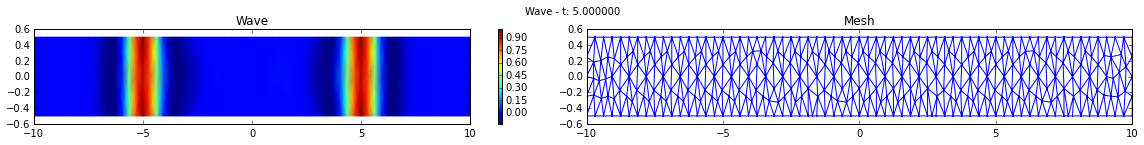

Relative L2_error= 0.0558851513585


In [3]:
%matplotlib inline                                                                                                                                                                                                                                            
%run /home/fenics/fenics-matplotlib.py                                                                                                                                                                                                                        
from dolfin import *; 
from mshr import *; 
from IPython.display import display, clear_output; 
import time
import logging; logging.getLogger('FFC').setLevel(logging.WARNING)

import numpy as np

set_log_active(False)

# Compact plot utility function
def plot_compact(u, t, stepcounter): 
    if stepcounter % 5 == 0:
        uEuclidnorm = project(u, Q); 
        ax.cla(); 
        fig = plt.gcf();
        fig.set_size_inches(16, 2)
        
        # Plot norm of velocity
        plt.subplot(1, 2, 1); 
        mplot_function(uEuclidnorm); 
        plt.title("Wave") 
        plt.colorbar(); 
        # plt.axis(G)
        
        # Plot mesh
        plt.subplot(1, 2, 2);
        plt.triplot(mesh2triang(mesh)); 
        plt.title("Mesh")
        plt.suptitle("Wave - t: %f" % (t)); 
        plt.tight_layout(); 
        clear_output(wait=True); 
        display(pl)   

# Define domain and mesh
XMIN, XMAX = -10., 10.;
YMIN, YMAX = -0.5, 0.5;
G = [XMIN, XMAX, YMIN, YMAX];
mresolution = 50;
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])), mresolution)

# Define function spaces and functions
Q = FunctionSpace(mesh, "CG", 1); 
W = Q * Q; 
h = CellSize(mesh);
(p, q) = TestFunctions(W); 
w = Function(W); 
(u, v) = (w[0], w[1]);
u0 = Function(Q); 
v0 = Function(Q);

# Time interval and time step
t, T = 0., 5.;
k = 0.05;
a = 1;

# Define the Dirichlet boundary   
def boundary(x, on_boundary):                                                                                                                                                                                                 
    return on_boundary

# Initial solution
option = 0;
if option==0:
    ue = Expression("(1-pow(a*t-x[0],2))*exp(-pow(a*t-x[0],2)) + (1-pow(a*t+x[0],2))*exp(-pow(a*t+x[0],2))", a=a, t=0, domain=mesh);
    ve = Expression("2*a*(a*t-x[0])*(pow(a*t-x[0],2)-2)*exp(-pow(a*t-x[0],2)) + 2*a*(a*t+x[0])*(pow(a*t+x[0],2)-2)*exp(-pow(a*t+x[0],2))", a=a, t=0, domain=mesh)
if option==1:
    ue = Expression("(1-pow(a*t+x[0],2))*exp(-pow(a*t+x[0],2))", a=a, t=0, domain=mesh);
    ve = Expression("2*a*(a*t+x[0])*(pow(a*t+x[0],2)-2)*exp(-pow(a*t+x[0],2))", a=a, t=0, domain=mesh)

# Boundary conditions
bcu = DirichletBC(W.sub(0), ue, boundary)
bcv = DirichletBC(W.sub(1), ve, boundary)
bcs = [bcu, bcv];

# Initial solution
u0 = ue;
v0 = ve;

# Time scheme parameter
theta = 0.5;

# Time-stepping loop    
while t < T:
    # Weak form of wave equation
    vm = theta*v + (1.0-theta)*v0;
    um = theta*u + (1.0-theta)*u0;
    ru=(u-u0)/k*p*dx - vm*p*dx
    rv=(v-v0)/k*q*dx + a*a*inner(grad(um),grad(q))*dx
    r = ru + rv;
    ue.t = t;
    ve.t = t;
    
    # Solve the wave equation (one time step)
    solve(r==0, w, bcs);
    
    # Visualize the solution
    pl, ax = plt.subplots();
    plot_compact(u, t, 0)
    plt.close();
    
    # Shift to next timestep                                                     
    u0 = project(u, Q);
    v0 = project(v, Q);
    t += k;
    e = u - ue;
    e1 = sqrt(assemble(e*e*dx))
    e2 = sqrt(assemble(ue*ue*dx))
    re = e1/e2
    print 'Relative L2_error=', re